In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Preprocessing
Implicit data에서 성능을 확인하기 위해  
Rating data를 0, 1로 변환하는 것이 아니라  


Implicit data 자체를 가져와 preprocessing함

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/dataset/research/events.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# user, item, addtocart로 구성된 df 만들기
df.drop(['timestamp', 'transactionid'], axis =1, inplace = True)

# 중복행 제거, index 재부여
df= df.sort_values('itemid')
df.drop_duplicates(inplace = True, ignore_index=True)

# 10개 이상 item을 본 user, item만 선택
value_counts = df['itemid'].value_counts()
to_keep = value_counts[value_counts > 20].index
df = df[df['itemid'].isin(to_keep)]

df= df.sort_values('visitorid')
df.drop_duplicates(inplace = True, ignore_index=True)

value_counts = df['visitorid'].value_counts()
to_keep = value_counts[value_counts > 20].index
df = df[df['visitorid'].isin(to_keep)]

# column 이름, addtocart 값 변경
df = df.rename(columns = {'visitorid':'user', 'itemid':'item', 'event':'addtocart'})
df = df.loc[df.addtocart == 'addtocart', ['user','item','addtocart']]
df.loc[df['addtocart'] == 'addtocart', 'addtocart'] = 1

print(df)

# df를 matrix로 변환
df_mat = df.pivot_table(index = 'user', columns = 'item', values = 'addtocart', fill_value=0)
mat_x= df_mat.to_numpy()

            user    item addtocart
158          172   10034         1
177          172  465522         1
6143        6699  401285         1
6151        6699   73602         1
6160        6699  210087         1
...          ...     ...       ...
1371933  1403769  248605         1
1371940  1403769   36810         1
1371980  1403769  436034         1
1371984  1403769    1987         1
1371991  1403769   73123         1

[9322 rows x 3 columns]


In [ ]:
print(mat_x)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
# 논문에서처럼 10개 이상 view 있는 경우만 남김
item_pick = np.count_nonzero(mat_x,axis=0) > 9
mat_x_tmp = mat_x[:][:,item_pick]

user_pick = np.count_nonzero(mat_x_tmp,axis=1) > 9
X_hat = mat_x[user_pick][:]


# processing 결과 확인
print(X_hat)

# user 수 확인
print(len(X_hat[:,0]))

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
2


In [ ]:
non_zero_counts = np.count_nonzero(X_hat, axis=1)
print(non_zero_counts)

[273 309]


In [ ]:
class BPR_MF():

  def __init__(self, data, epochs = 100000, learning_rate = 0.01, feat_dim = 30, lambd = 0.01, patience = 20000):
    self.data = data
    self.epochs = epochs
    self.learning_rate = learning_rate
    self.feat_dim = feat_dim
    self.lambd = lambd
    self.patience = patience

  def fit(self):
    # init factorization matrix W, H
    W = np.random.random((self.data.shape[0], self.feat_dim))
    H = np.random.random((self.feat_dim, self.data.shape[1]))

    # init return list, condition
    AUC = []
    num_epochs = []
    last_AUC = 0
    avg_AUC = 0
    sum_AUC =0

    for iter in range(1, self.epochs+1):

      # bootstrap sampling : sample size = 1
      u = np.random.choice(range(self.data.shape[0]))
      if (np.where(self.data[u] == 1)[0] == [] or np.where(self.data[u] == 0)[0] == []):
        continue
      i = np.random.choice(np.where(self.data[u] == 1)[0])
      j = np.random.choice(np.where(self.data[u] == 0)[0])

      ### Update gradient for each triples ###
      # feature vector of each user, item
      w_u = W[u, :]
      h_i = H[:, i]
      h_j = H[:, j]

      # logistic sigmoid part
      x_uij = np.dot(w_u, h_i) - np.dot(w_u, h_j)
      exp = np.exp(-x_uij) / (1 + np.exp(-x_uij))

      # gradient derivatives
      grad_u = exp * (h_i-h_j) + self.lambd * w_u
      grad_i = exp * w_u + self.lambd * h_i
      grad_j = exp * (-w_u) + self.lambd * h_j

      # stochastic gradient descent
      W[u,:] = W[u,:] + self.learning_rate * grad_u
      H[:,i] = H[:,i] + self.learning_rate * grad_i
      H[:,j] = H[:,j] + self.learning_rate * grad_j

      ### AUC calculation for each 100000 epochs ###
      # 평가할때마다 O(|U||I+|I/I+|)만큼씩 소요됨.. 이게 아닌가
      """AUC = 0
      if iter % 1000 == 0:
        for user in range(self.data.shape[0]):
          z_u_inv = len(np.where(self.data[user] == 1)) * len(np.where(self.data[user] == 1))
          sum_delta = 0
          for i in np.where(self.data[user] == 1)[0]:
            for j in np.where(self.data[user] == 0)[0]:
              auc_w_u = W[user, :]
              auc_h_i = H[:, i]
              auc_h_j = H[:, j]
              auc_x_uij = np.dot(w_u, h_i) - np.dot(w_u, h_j)
              if auc_x_uij > 0:
                sum_delta += 1
          AUC += sum_delta / z_u_inv
        avgAUC = AUC / self.data.shape[0]
        print("epoch:", iter, "/ avgAUC:", avgAUC)"""

      # 해당 iteration의 user에서만 AUC 계산
      z_u_inv = len(np.where(self.data[u] == 1)) * len(np.where(self.data[u] == 1))
      if x_uij > 0:
        sum_AUC += 1
      avg_AUC = sum_AUC / iter
      if iter % 100 == 0:
        AUC.append(avg_AUC)
        num_epochs.append(iter)
        print("epoch:",iter,"/ AUC:", avg_AUC)
      if iter % 1000 == 0:
        print("self.patience:", self.patience)

      # earlystopping
      if (avg_AUC - last_AUC) < 0.0000001:
        self.patience -= 1
      last_AUC = avg_AUC
      if self.patience == 0:
        return AUC, num_epochs

    return AUC, num_epochs


In [ ]:
bpr_mf = BPR_MF(X_hat)
auc, epoch = bpr_mf.fit()

<ipython-input-42-4b4f975bf012>:27: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if (np.where(self.data[u] == 1)[0] == [] or np.where(self.data[u] == 0)[0] == []):


epoch: 100 / AUC: 0.6
epoch: 200 / AUC: 0.505
epoch: 300 / AUC: 0.5166666666666667
epoch: 400 / AUC: 0.535
epoch: 500 / AUC: 0.51
epoch: 600 / AUC: 0.52
epoch: 700 / AUC: 0.5171428571428571
epoch: 800 / AUC: 0.52625
epoch: 900 / AUC: 0.5322222222222223
epoch: 1000 / AUC: 0.532
self.patience: 19533
epoch: 1100 / AUC: 0.53
epoch: 1200 / AUC: 0.5333333333333333
epoch: 1300 / AUC: 0.5330769230769231
epoch: 1400 / AUC: 0.54
epoch: 1500 / AUC: 0.54
epoch: 1600 / AUC: 0.54
epoch: 1700 / AUC: 0.5464705882352942
epoch: 1800 / AUC: 0.5455555555555556
epoch: 1900 / AUC: 0.5394736842105263
epoch: 2000 / AUC: 0.5425
self.patience: 19085
epoch: 2100 / AUC: 0.5466666666666666
epoch: 2200 / AUC: 0.5459090909090909
epoch: 2300 / AUC: 0.5473913043478261
epoch: 2400 / AUC: 0.5479166666666667
epoch: 2500 / AUC: 0.5516
epoch: 2600 / AUC: 0.5538461538461539
epoch: 2700 / AUC: 0.5551851851851852
epoch: 2800 / AUC: 0.5575
epoch: 2900 / AUC: 0.5572413793103448
epoch: 3000 / AUC: 0.559
self.patience: 18678
epoc

<function matplotlib.pyplot.show(close=None, block=None)>

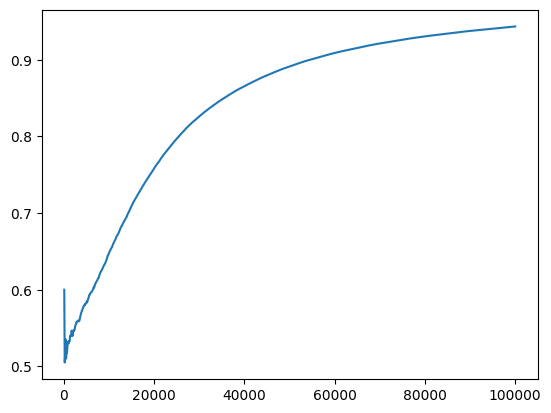

In [ ]:
plt.plot(epoch, auc)
plt.show